In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.layers.merging import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import EarlyStopping
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import io
from PIL import Image, ImageFilter
import cv2
import os
import requests
import pandas as pd
from urllib.request import urlopen

In [ ]:
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.layers.activation.prelu import PReLU
from keras.layers.reshaping.cropping2d import Cropping2D

In [ ]:
from roughviz.charts import Line
from cutecharts.charts import Line
from keras.callbacks import LearningRateScheduler


In [ ]:
path = "photos/train/"
testPath = "photos/test/"

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(path, target_size=(256,256), batch_size=25, class_mode=None)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(testPath, target_size=(256, 256), batch_size=25, class_mode=None)

# **Convolutional Neural Network**

## Model Testing Ideas:

* Using different types of activation functions. 
    - PreLU
    - <mark>Leaky ReLU</mark>
    - ReLU
* Changing the validation
    - <mark>with</mark> or without validation set
    - validation steps
* Changing the complexity of the model. 
    - conv2D based network with incrementing filter sizes until 256 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 128 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 64 and decrementing back to 16
    - only increments
* Using different preprocessing techniques
    - adding blur to images before entering the network
    - trying differently sized images
    - maybe some kind of other smoothing or denoising effect
* Trying different learning rates
* Trying different optimizers
* Image Augmentation
* Different Datasets

In [268]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
#            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [269]:
X_,y_ = ExtractInput(ImagePath)

In [270]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [265]:
X_[0].shape

(256, 256)

In [266]:
X_test[0].shape

(256, 256)

In [272]:
np.unique(y_[55])

array([-21.546875,   0.      ,  94.46875 ], dtype=float32)

In [ ]:
from keras.layers.core.dense import Dense
from keras.layers import Dropout

In [273]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
#    model_ = Dense(units=2)(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [274]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [275]:
initial_learning_rate = 0.01
epochs = 3
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * (1 / (1 + decay * epoch))

In [276]:
LEARNING_RATE = 0.01
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error', metrics=["acc"])
Model_Colourization.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_83 (Conv2D)             (None, 256, 256, 16  160         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_48 (LeakyReLU)     (None, 256, 256, 16  0           ['conv2d_83[0][0]']              
                                )                                                          

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ormalization)                  )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 256, 256, 64  0           ['batch_normalization_36[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_91 (Conv2D)             (None, 256, 256, 32  18464       ['dropout_1[0][0]']              
                                )                                                                 
                                                                                                  
 leaky_re_lu_56 (LeakyReLU)     (None, 256, 256, 32  0           ['conv2d_91[0][0]']              
                                )                                                                 
          

In [277]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[es])
history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=40, callbacks=[es])#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])

C:\Users\jrsco\AppData\Local\Temp\ipykernel_30372\2244812203.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=40, callbacks=[es])#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])


Epoch 1/12
5/5 [==============================] - 30s 6s/step - loss: 217.1158 - acc: 0.3009 - val_loss: 138.4128 - val_acc: 0.0291
Epoch 2/12
5/5 [==============================] - 34s 8s/step - loss: 110.2963 - acc: 0.2438 - val_loss: 129.6737 - val_acc: 0.0384
Epoch 3/12
5/5 [==============================] - 34s 8s/step - loss: 143.4883 - acc: 0.3693 - val_loss: 83.5267 - val_acc: 0.9830
Epoch 4/12
5/5 [==============================] - 35s 8s/step - loss: 13.7744 - acc: 0.7251 - val_loss: 63.0178 - val_acc: 0.9804
Epoch 5/12
5/5 [==============================] - 32s 8s/step - loss: 198.5340 - acc: 0.8063 - val_loss: 94.4919 - val_acc: 0.9520
Epoch 6/12
5/5 [==============================] - 23s 5s/step - loss: 393.3561 - acc: 0.6421 - val_loss: 101.9943 - val_acc: 0.9785
Epoch 7/12
5/5 [==============================] - 21s 5s/step - loss: 2.5165 - acc: 0.1038 - val_loss: 143.1466 - val_acc: 0.9694
Epoch 8/12
5/5 [==============================] - 21s 5s/step - loss: 34.9690 - ac

In [278]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [279]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

In [285]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_=img.astype(np.float32)

    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [286]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 305ms/step
Prediction made
reshaped


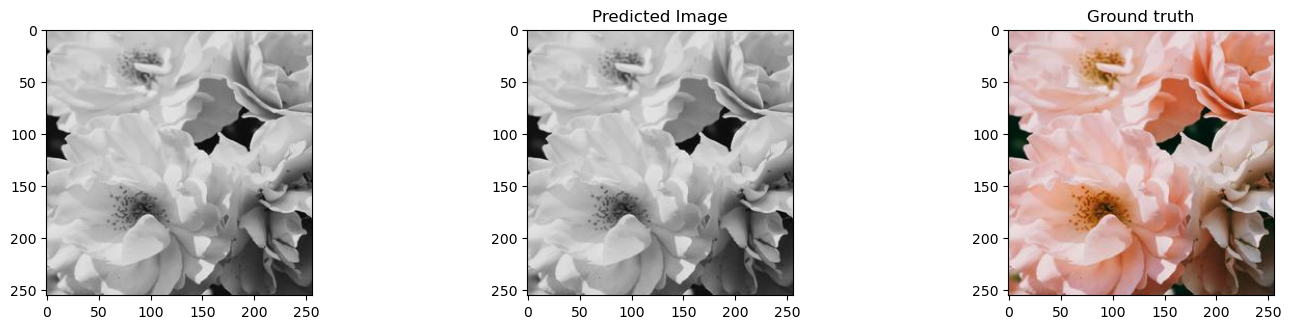

In [287]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

# **Autoencoder Method**

## Setup

In [ ]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
#            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [ ]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [23]:
np.unique(X_[43])

array([ 91.11328,  97.13745, 100.     ], dtype=float32)

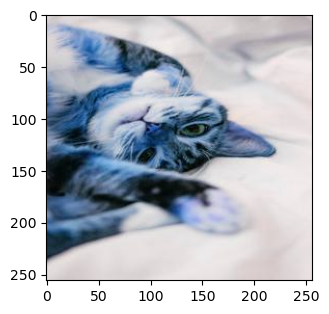

In [253]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath+"cat.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

In [9]:
np.unique(y_[55])

array([-21.546875,   0.      ,  94.46875 ], dtype=float32)

In [ ]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [14]:
def InstantiateAutoencoderModel(in_):
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
#    model_ = Dropout(rate=0.2)(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)


    print(model_)
    print(in_)

    concat_ = concatenate([model_, in_]) 

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(16,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
#    model_ = Dense(units=2)(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)
    model_ = UpSampling2D((2,2))(model_)    

    return model_

In [15]:
def initAutoEncoder(in_):
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)


    print(model_)
    print(in_)
    
#    model_ = Dropout(rate=0.2)(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(256, (3,3), padding="same", strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(128, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(64, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(16, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(15,(1,1), activation='softmax',padding='same',strides=1)(model_)
   # model_ = UpSampling2D((2,2))(model_)    

    print(model_)
    print(in_)

    return model_

In [16]:
from keras.layers import Flatten
from keras.layers import Dense

In [17]:
# Input layer
input_img = Input(shape=(256, 256, 1))

# Encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Flatten and Dense layers for non-spatial feature extraction
#flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(pool2)
dense2 = Dense(64, activation='relu')(dense1)
print(dense2)
# Decoder
upsample1 = UpSampling2D((2, 2))(dense2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(upsample1)
upsample2 = UpSampling2D((2, 2))(conv3)
decoded = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(upsample2)

# Define the model
autoencoder = Model(input_img, decoded)

# Compile the model
#autoencoder.compile(optimizer='adam', loss='mse')

# Print the model summary
#autoencoder.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")


In [18]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [19]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = initAutoEncoder(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 256), dtype=tf.float32, name=None), name='up_sampling2d_2/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 15), dtype=tf.float32, name=None), name='conv2d_12/Softmax:0', description="created by layer 'conv2d_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [20]:
from keras.losses import MeanAbsolutePercentageError

In [21]:
import tensorflow as tf

In [188]:
def lossle(y_true, y_pred):
   C_pred = (y_pred[0]**2 + y_pred[1]**2)
   C_true = (y_true[0]**2 + y_true[1]**2)
   loss = tf.sqrt(C_pred - C_true)
   #h_pred = tf.atan2(y_pred[1], y_pred[0])
   #h_true = tf.atan2(y_true[1], y_true[0])
   #loss = (tf.sqrt((C_true - C_pred)**2 + 0.01*(h_true - h_pred)**2))#/(100.64)
 #   loss = tf.sqrt((y_true[0]-y_pred[0])**2 + (y_true[1] - y_pred[1])**2)
   return loss

In [13]:
def custom_loss(y_true, y_pred):
    # Split the predicted and ground truth tensors into a and b channels
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    # Compute the Euclidean distance between a and b channels
    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    
    # Compute hue and saturation from a and b channels of predicted image
    hue_true = tf.math.atan2(b_true, a_true)
    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    hue_pred = tf.math.atan2(b_pred, a_pred)
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    
    # Define the weighting factor for emphasizing saturation over hue
    saturation_weight = 2.0
    
    # Compute the weighted hue-saturation loss
    hue_saturation_loss = tf.square(hue_pred - hue_true) + saturation_weight * tf.square(saturation_pred - saturation_true)
    
    # Combine the color loss and hue-saturation loss
    total_loss = color_loss + hue_saturation_loss
    
    # Return the mean loss over the batch
    return tf.reduce_mean(total_loss)


In [23]:
# Compile the model
#autoencoder.compile(optimizer=Adam(lr=0.0005), loss=custom_loss, metrics=["acc"])
Model_Colourization.compile(optimizer='adam', 
                          loss=[custom_loss, 'categorical_crossentropy'], metrics=["acc"],
                          loss_weights=[1.0, 1.0])
# Print the model summary
Model_Colourization.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 64  0           ['conv2d_4[0][0]']               
                                )                                                           

In [191]:
lossle([0.1,1.2], [1.4,2.2])

<tf.Tensor: shape=(), dtype=float32, numpy=2.3130066>

In [192]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss=custom_loss, metrics=["acc"])
Model_Colourization.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_73 (Conv2D)             (None, 256, 256, 16  160         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_39 (LeakyReLU)     (None, 256, 256, 16  0           ['conv2d_73[0][0]']              
                                )                                                          

In [193]:
initial_learning_rate = 0.001
epochs = 12
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [194]:
from keras.callbacks import LearningRateScheduler

In [ ]:
def convert_list_to_color_bins(image_list, num_bins):
    bins_list = []
    
    for image in image_list:
        min_value = np.min(image)
        max_value = np.max(image)
        range_value = max_value - min_value
        bin_width = range_value / num_bins
        
        bins = np.zeros_like(image, dtype=np.float32)
        
        for i in range(num_bins):
            bin_min = min_value + i * bin_width
            bin_max = min_value + (i + 1) * bin_width
            mask = np.logical_and(image >= bin_min, image < bin_max)
            bins[mask] = 1.0
        
        bins_list.append(bins)

    
    return np.array(bins_list)


In [ ]:
image_list_bins = convert_list_to_color_bins(y_, num_bins)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D

# Define the model architecture
print("Defining the architecture.")
model = keras.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
print("Model compiled")


# Convert the y_train_resized to binary color maps
print("Creating the binary color maps")
y_train_binary = convert_list_to_color_bins(y_, num_bins=15)  # Assuming you have implemented the function
y_test_binary = convert_list_to_color_bins(y_test, num_bins=15)  # Assuming you have implemented the function
# Train the model
#print("Training the model")
#model.fit(X_, y_train_binary, batch_size=32, epochs=10)


In [ ]:
X_.shape

(1498, 256, 256)

In [61]:
y_.shape

(1498, 256, 256, 2)

In [63]:
y_train_binary.shape

(1498, 256, 256, 2)

In [47]:
y9 = convert_list_to_color_bins([y_[9]], 15)

In [48]:
np.unique(y9)

array([0., 1.], dtype=float32)

In [40]:
np.unique(y_[9])

array([-107.859375,  -86.1875  ,  -60.828125,  -48.09375 ,  -21.546875,
        -14.125   ,    0.      ,   67.203125,   79.1875  ,   80.09375 ,
         83.171875,   94.46875 ,   98.234375], dtype=float32)

In [302]:
np.unique(image_list_bins[2])

array([1.], dtype=float32)

In [28]:
np.unique(y_[3])

array([-60.828125, -21.546875,   0.      ,  67.203125,  80.09375 ,
        94.46875 ,  98.234375], dtype=float32)

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        X_input = X_input.astype(float)
        y_input = y_[i].reshape(1,256,256,2)
        y_input = y_input.astype(float)
        yield (X_input,y_input)

es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)
history = model.fit_generator(GenerateInputs(X_,y_train_binary),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test_binary), validation_steps=10)#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])

In [ ]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [ ]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

In [30]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [ ]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
TestImagePath2="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
img2 = cv2.imread(TestImagePath2)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
image_for_test2 = ExtractTestInput(img2)
print("Extracted output")
#print(image_for_test)
Prediction = model.predict(image_for_test)
print("Prediction made")
#Prediction = Prediction*128
#Prediction=Prediction.reshape(256,256,2)
print("reshaped")

In [ ]:
def convert_color_bins_to_image(pred_binary_map):
    bin_width = 256 / len(pred_binary_map)
    colorized_img = np.zeros((256, 256, 3))
    
    for i in range(len(pred_binary_map)):
        mask = pred_binary_map[..., i] == 1
        bin_min = -128 + i * bin_width
        bin_max = bin_min + bin_width
        print(colorized_img)
        colorized_img[..., 0][mask] = 0  # Set L channel to 0
        colorized_img[..., 1][mask] = (bin_min + bin_max) / 2
        colorized_img[..., 2][mask] = bin_min + bin_width / 2
    
    # Convert Lab image to RGB
    colorized_img = cv2.cvtColor(colorized_img.astype(np.float32), cv2.COLOR_LAB2RGB)
    
    return colorized_img

In [ ]:
y_pred = model.predict([image_for_test])

In [ ]:
y_pred2 = model.predict(image_for_test2)

In [ ]:
pred_binary_map = convert_list_to_color_bins(y_pred, 15)

In [ ]:
colorized_img = convert_color_bins_to_image(pred_binary_map)

In [108]:
def convert_list_to_color_bins(color_list):
    num_bins = color_list.shape[-1]
    bins = np.zeros((256, 256, num_bins))
    bin_edges = np.linspace(-128, 128, num_bins + 1)

    for i in range(num_bins):
        bin_min = bin_edges[i]
        bin_max = bin_edges[i + 1]
        mask = np.logical_and(color_list[..., i] >= bin_min, color_list[..., i] < bin_max)
        mask = mask.reshape((256, 256, 1))
        print(mask.shape)
        print(bins.shape)
        bins[mask, i] = 1.0

    return bins


In [ ]:
def convert_list_to_color_bins(image_list, num_bins):
    bins_list = []
    
    for image in image_list:
        min_value = np.min(image)
        max_value = np.max(image)
        range_value = max_value - min_value
        bin_width = range_value / num_bins
        
        bins = np.zeros_like(image, dtype=np.float32)
        
        for i in range(num_bins):
            bin_min = min_value + i * bin_width
            bin_max = min_value + (i + 1) * bin_width
            mask = np.logical_and(image >= bin_min, image < bin_max)
            bins[mask] = 1.0
        
        bins_list.append(bins)

    
    return np.array(bins_list)


In [ ]:
# Assuming you have trained your model and obtained the predicted color values
y_pred = model.predict(image_for_test)  # Replace `X_test` with your test data

# Convert the predicted color values to binary map
pred_binary_map = convert_list_to_color_bins(y_pred)

# Reshape the binary map to match the original image size
pred_binary_map = pred_binary_map.reshape(-1, image_for_test.shape[1], image_for_test.shape[2])

# Convert the binary map to colorized image
colorized_img = convert_color_bins_to_image(pred_binary_map)

# Display the colorized image
cv2.imshow("Colorized Image", colorized_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


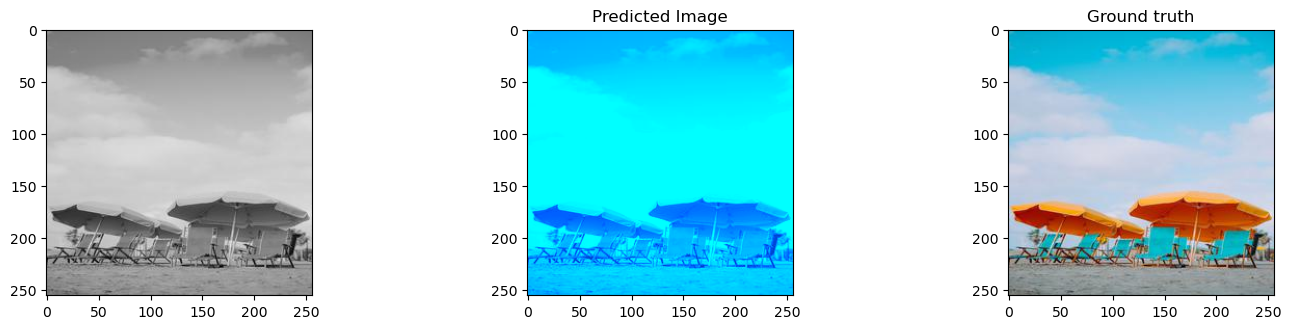

In [37]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)